In [0]:
!nvidia-smi

Tue May 21 19:23:33 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install imgaug

In [0]:
import numpy as np
import random
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from sklearn.model_selection import train_test_split

In [0]:
!pip install livelossplot

In [0]:
from livelossplot import PlotLossesKeras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
X = np.load('X.npy')
y = np.load('y.npy')

In [0]:
print(X.shape, y.shape)

(5382, 60, 80, 3) (5382,)


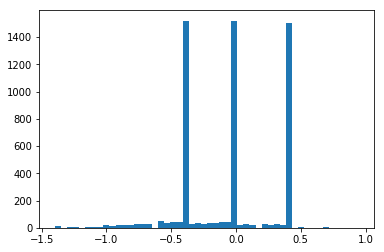

In [0]:
plt.hist(y, 50);

In [0]:
def augment(img, steering_angle):
  # flip
  if random.random() >0.5:
    img = img[:, ::-1, :]
    steering_angle = - steering_angle
  # blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1, 1.0))
  img = blurer.augment_image(img)
  # RGB shuffle
  shuffle = iaa.ChannelShuffle(p = 0.5)
  img = shuffle.augment_image(img)
  # fog
  fog = iaa.Fog()
  img = fog.augment_image(img)
  #translate
  tx = random.randint(-20,20)
  translate = iaa.Affine(translate_px = {"x":tx}, mode ='edge')
  img = translate.augment_image(img)
  steering_angle += tx *0.25
  return img, steering_angle

0.0


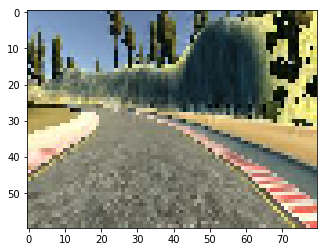

-2.75


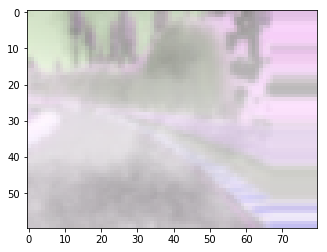

In [0]:
plt.imshow(X[0])
print(y[0])
plt.show();

img, angle = augment(X[0], y[0])
plt.imshow(img)
print(angle)
plt.show();

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [0]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(4305, 60, 80, 3) (4305,)
(1077, 60, 80, 3) (1077,)


In [0]:
Xgen = []
ygen = []
for i in range (X_train.shape[0]):
  img, angle = augment(X[i],y[i])
  Xgen.append(img)
  ygen.append(angle)


Xgen = np.array(Xgen)
ygen = np.array(ygen)
print(Xgen.shape, ygen.shape)

(4305, 60, 80, 3) (4305,)


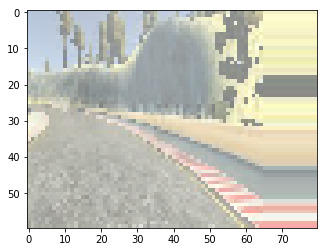

In [0]:
plt.imshow(Xgen[0])

In [0]:
# plt.hist(y_train, 50, facecolor = 'green');
plt.hist(ygen, 50, facecolor = "red");

In [25]:
def mymodel (input_shape):
  model = Sequential([
      Lambda(lambda x: (x - 128.0)/225.0, input_shape = input_shape),
      
      Conv2D(64, (3,3), activation = "relu"),
      
      Conv2D(32, (3,3), activation = "relu"),
      MaxPooling2D(pool_size = (2,2)),
      Conv2D(16, (3,3), activation = "relu"),
      MaxPooling2D(pool_size = (2,2)),
      Conv2D(8, (3,3), activation = "relu"),
      MaxPooling2D(pool_size = (2,2)),
      Dropout(rate = 0.3),
      Flatten(),
      Dense(512, activation = "relu"),
      Dropout(rate = 0.3),
      Dense(512, activation = "relu"), 
      Dropout(rate = 0.3),
      Dense(32, activation = "relu"), 
      Dropout(rate = 0.3),
      Dense(16, activation = "relu"), 
      Dense(1), 
      
  ])
  return model 
model = mymodel(X[0].shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 18, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 11, 16, 8)         1160      
__________

In [0]:
model.compile( 'adam', 'mse')

In [0]:
batch_size = 512

epochs = 30

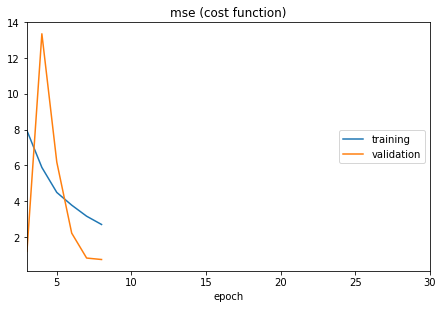

mse (cost function):
training   (min:    2.702, max:    8.678, cur:    2.702)
validation (min:    0.123, max:   13.345, cur:    0.747)
Epoch 9/30
1024/4305 [======>.......................] - ETA: 1s - loss: 2.3748

In [0]:
model.fit(Xgen, ygen,
          batch_size = batch_size , 
          epochs = epochs, 
          validation_data = (X_val, y_val),
          callbacks = [PlotLossesKeras()]
         )

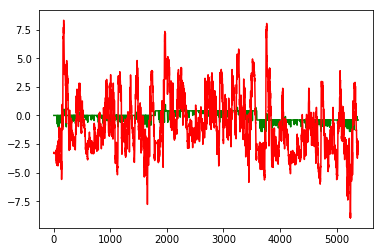

In [0]:
ypred = model.predict(X)
plt.plot(y, 'g', ypred, 'r')
plt.show();

In [0]:
model.save('mymodel.h5')